# Homework 2


## Mc-Call Job Search Model with Separation

We consider here a very simple job-search model, with separation. Our goal consists in solving this model using a policy iteration algorithm. Some background on the McCall and numerical ideas are discussed on the [QuantEcon](`https://julia.quantecon.org/mccall_model.html`) website.

There is a single worker who can be either employed ("e") or unemployed ("u") in any period.

When unemployed, the jobless worker receives unemployment benefits $c_t=\alpha>0$ in every period as long as he stays unemployed. He also receives a salary offer $w_t$ which is drawn from a discrete i.i.d. distribution and takes values $w_1, ..., w_K$ with probabilities $p_1, ... p_K$ respectively.

When an unemployed worker accepts an offer in period $t$, he gets the salary $w_t$ and becomes employed. He then keeps his salary $w_t$ as long as he stays employed (for $s\geq t$, $c_s=w_t$ if $t$ is the date at which worker got the current job); in each period he has a probability $\lambda$ of becoming unemployed in the next period and remains employed otherwise.

When a worker receives a given amount $x$ his perceived utility is $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ with $\gamma>1.0$. A worker discounts the future at a rate $\beta \in [0,1[$. As a result, in any period $t_0$ workers seek to maximize $\sum_{t\geq t_0}^{\infty} U(c_t)$.


__Define a parameter type `Parameter`, with fields $\alpha$, $\beta$, $\gamma$, $K$, $\sigma$, $\lambda$. Create a parameter variable $\omega$ with $\alpha=0.5$, $\beta=0.96$, $\gamma=4$, $K=10$, $\sigma=0.6$, $\lambda=0.015$__

In [2]:
struct Parameter
    alpha::Float64
    beta::Float64
    gamma::Float64
    K::Int
    sigma::Float64
    lambda::Float64
end

ω = Parameter(0.5, 0.96, 4., 10, 0.6, 0.015)

Parameter(0.5, 0.96, 4.0, 10, 0.6, 0.015)

__What is the uniform distribution, whose mean is 1 and standard deviation is $\sigma$? Write a function `discrete_uniform(σ::Float64, K::Int64)::Tuple{Vector{Float64} Vector{Float64}}` to discretize it, using $K$ points. The function should return two vectors `w` and `p` of floats of the same size `K`. Check the results satisfy the right conditions (uniformity, standard deviation).__

The uniform distribution whose mean is $1$ and whose standard deviation is $\sigma$ is $\mathcal{U}\left(1-\sigma \sqrt{3},1+\sigma \sqrt{3} \right)$.

In [3]:
import Pkg; Pkg.add("Distributions")
import Pkg; Pkg.add("NLsolve")

  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]


In [4]:
function discrete_uniform(sigma::Float64, K::Int64)
    w = collect(LinRange(1-sqrt(3)*sigma, 1+sqrt(3)*sigma, K))
    p = [1/K for i = 1:K]
    return w, p 
end

discrete_uniform (generic function with 1 method)

In [5]:
using LinearAlgebra
w,p = discrete_uniform(ω.sigma, ω.K)
mean = dot(w, p)
std = sqrt(dot((w-ones(ω.K)).^2, p))

0.6633249580710798


The optimal decision of a worker is characterized by two value functions: $V^E(w)$ is the value of being employed at wage $w$ and $V^U(w)$ the value of being unemployed, while receiving job offer $w_t$. In Julia, both $V^U$ and $V^E$ will be represented by arrays `V_U` and `V_E` of size `K`.

A policy `g(w)` is a binary choice in the unemployed state: accept or reject an offer $w_t$. It will then naturally be represented by a boolean array (type `zeros(Bool, K)` to initialize one).

__Given a policy $g$, write down the recursive equations which defines the corresponding value functions $V^{U,g}(w)$ and $V^{E,g}(w)$.__

Let us define the following expression for $V^{E}_{t}(w)$:

$$
V^{E}_{t}(w) = U(w) +\beta \left( \lambda V_{t+1}^U(w) + (1-\lambda)V_{t+1}^E(w)\right) 
$$

And the following expression for $V^{U}_{t}(w)$:

$$
V^{U}_{t}(w) = U(\alpha)+\beta . \mathbb{E}\left[ \max(V_{t+1}^U(w),V_{t+1}^E(w)) \right] 
$$

Then we have that: \
$$
V^g(w) = V^E(w)g(w) + (1-g(w)) V^U(w)
$$

__Write a function which takes a guess $V^{U,g}(w)$ and $V^{E,g}(w)$ and a policy function $g$ as arguments (and other model parameters) and updates the values, according to the updating equations. This function could have signature `value_update(V_U::Vector{Float64}, V_E::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})::Vector{Float64}` where the returned vector has the same size as the supplied ones.__

In [21]:
function value_update(V_E::Vector{Float64}, V_U::Vector{Float64}, g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64})
    V_Ebis = w.^(1-ω.gamma)/(1-ω.gamma) .+ ω.beta*(ω.lambda .* V_U + (1-ω.lambda).*V_E)
    V_Ubis = ω.alpha^(1-ω.gamma)/(1-ω.gamma) .+ ω.beta.* ones(length(V_U)).* (dot(max.(V_U,V_E),p))
    return V_Ebis, V_Ubis
end

value_update (generic function with 1 method)


__Write a function `eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Tuple{Vector{Float64}, Vector{Float64}}` which iterates on `value_update` find the values that satisfy the evaluation equations for policy `g`.__


In [7]:
distance(X::Vector{Float64}, Y::Vector{Float64}) = maximum((u) -> abs(u[1]-u[2]), zip(X[1],Y[1]))

distance (generic function with 1 method)

In [8]:
function eval_policy(g::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64, V_E, V_U)
    V0 = (V_E, V_U)
    V0_sum = V_E.*g + V_U.*(1 .- g)
    V_E, V_U = value_update(V_E, V_U, g, ω, w, p)
    V_sum = zeros(length(V_U))
    ind = 0
    while distance(V_sum, V0_sum) > η
        V_0 = (V_E, V_U)
        V_E, V_U = value_update(V_E, V_U, g, ω, w, p)
        V_sum = V_E.*g + V_U.*(1 .- g)
        V0_sum = V_0[1].*g + V_0[2].*(1 .- g)
        ind += 1
    end
    return V_E, V_U
end

eval_policy (generic function with 1 method)


__Write a function `improve_policy(g::Vector{Bool}, V_U::Vector{Bool}, V_E::Vector{Bool}, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)::Vector{Float64}` which returns the improved policy given guesses for the value function(s) at for $t+1$.__

In [9]:
function improve_policy(g::Vector{Bool}, V_E, V_U, ω::Parameter, w::Vector{Float64}, p::Vector{Float64}, η::Float64)
    V_Ebis, V_Ubis = eval_policy(g, ω, w, p, η, V_E, V_U)
    return convert(Vector{Bool},V_Ebis .> V_Ubis)
end

improve_policy (generic function with 1 method)

__Implement the policy function algorithm. Print the successive approximation errors and comment on the convergence speed.__

In [10]:
import Pkg; Pkg.add("Distances")
using Distances

Tmax = 10000
η = 0.0001
g = zeros(Bool, ω.K)
g0 = g[1]
V_E = ones(ω.K)*0.1
V_U = ones(ω.K)*0.2
V_sum0 = V_E.*g0 + V_U.*(1 .- g0)
V_sums = zeros(Tmax, ω.K)
gs = zeros(Bool, Tmax, ω.K)
V_sums[2,:] = V_sum0
gs[2, :] = g
errors = zeros(Tmax)
ind = 2

while (distance(V_sums[ind-1,:], V_sums[ind,:]) > η) && (ind < Tmax+1)
    V_E, V_U = eval_policy(g, ω, w, p, η, V_E, V_U)
    g = improve_policy(g, V_E, V_U, ω, w, p, η)
    V_sum = V_E.*g + V_U.*(1 .- g)
    V_sums[ind+1, :] = V_sum
    gs[ind+1, :] = g
    ind += 1
end

  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]


  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]


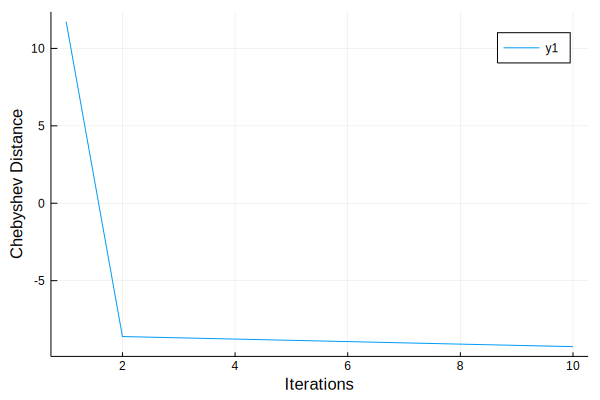

In [25]:
using Distances
import Pkg; Pkg.add("Plots")
using Plots

V1 = V_sums[2:ind-1,:]
V2 = V_sums[3:ind,:]
distances = [chebyshev(V1[i,:],V2[i,:]) for i in 1:ind-2]

plt = plot(log.(distances))
xlabel!(plt,"Iterations")
ylabel!(plt,"Chebyshev Distance")


## Neoclassical growth model (2)

We consider here, another deterministic version of the neoclassical growth model, but propose a slightly different solution method.

A representative agent uses capital $k_t$ to produce $y_t$ using the following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what remains:

$$i_t = y_t - c_t$$.

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount factor.

Since the problem is time homogenous, the value function depends on available capital only and satisfies the following Bellman equation:

$$V\left(\underbrace{k}_{k_t}\right) = \max_{c\in[0,1[} U(c) + \beta V\left(\underbrace{(1-\delta)k + \underbrace{(k^{\alpha}-c)}_{y_{t+1}}}_{k_{t+1}}\right)$$

Our goal is to obtain a smooth approximation of $k$ and $V$ by using interpolations techniques.

For this model, using the dynamic first-order conditions, one can show the deterministic steady-state of the model satisfies $1=\beta \left( (1-\delta) + \alpha k^{\alpha -1} \right)$. 

__Create a suitable Parameter type to hold the parameters. Write a function `steady_state(p::Parameter)` to compute the steady-state capital `kbar` and the corresponding steady-state consumption `cbar`__ 


In [12]:
struct Parameter_2
    alpha::Float64
    beta::Float64
    gamma::Float64
    delta::Float64
end

In [13]:
function steady_state(p::Parameter_2)
    kbar = ((1/p.beta+p.delta-1)/p.alpha)^(1/(p.alpha-1))
    cbar = kbar^p.alpha-p.delta*kbar
    return kbar, cbar
end

steady_state (generic function with 1 method)

__Set $N=10$ and define a reasonable grid `kgrid=range(kmin, kmax; length=N)` to approximate capital $k$.__


In [14]:
N = 10
p = Parameter_2(0.3, 0.96, 0.4, 0.059) 
kbar, cbar = steady_state(p)

kmin = (1-0.5)*kbar;
kmax = (1+0.5)*kbar;

kgrid=range(kmin, kmax; length = N);

__The unknown value function is represented as a `N` elements arrays. Define `Vi(k,p)=U(δ * k^α)/(1-𝛽)` and compute the initial guess `V0 = [Vi(k,p) for k in kgrid]`. Define a finer grid `ktest=range(kmin, kmax;length=1000)` and find the values of `Vi` on it by  using `Interpolations.jl` library to interpolate `V0` between the points of `kgrid`.__


In [15]:
import Pkg; Pkg.add("Interpolations")
using Interpolations

  Resolving package versions...
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.juliapro/JuliaPro_v1.4.0-1/environments/v1.4/Manifest.toml`
 [no changes]


In [16]:
Vi(k,p) = (p.delta * k^p.alpha)^(1-p.gamma)/((1-p.beta)*(1-p.gamma))
V0 = [Vi(k,p) for k in kgrid];
ktest = range(kmin, kmax; length = 500);
V0test = [Vi(k,p) for k in ktest];
itp = interpolate(V0, BSpline(Linear()))
sitp = scale(itp, kgrid);


__Compute a Bellman improvement function `bellman(V0::Vector{Float64}, p::Parameter, kgrid)::Tuple{Vector{Float64}, Vector{Float64}}` which does the following steps:__

- take an initial guess `V0` for the value function

- at each grid point from kvec, optimize nonlinearly, the function $c \rightarrow U(c) + \beta V\left((1-\delta)k + (k^{\alpha}-c)\right)$ for each capital level in the grid `kvec`. In this expression the function `V()` interpolates `V0` defined on `kvec` on any point `k` so that the resulting function is continuous. 

- return the updated value and investment rules

In [17]:
function bellman(V0::Vector{Float64}, p::Parameter_2, kgrid)
    V = deepcopy(V0)
    C = zeros(length(V0))
    for (n,k) in enumerate(kgrid)
        nn0 = -1
        gv = -Inf
        copt = - 1.0
        for (nn,kk) in enumerate(kgrid)
            y = k^p.alpha
            i = kk - (1 - p.delta)*k
            c = y - i
            if c < 0
                continue
            end
            itp = interpolate(V0, BSpline(Linear()))
            sitp = scale(itp, kgrid)
            esitp = extrapolate(sitp,Line());
            v = c^(1-p.gamma)/(1-p.gamma)+p.beta*esitp((1-p.delta)*kk+kk^p.alpha-c)
            if v > gv
                gv = v
                copt = c
                nn0 = nn
            end
        end
        V[n] = gv
        C[n] = copt
    end
    return V, C
end

bellman (generic function with 1 method)


__Write a value interation function `vfi(N, p)` which solves the model defined by parameter `p` using the value function algorithm. The function should return the value function and the policy rule.__


In [18]:
function vfi(V0, p, tol, kgrid)
    V0 = deepcopy(V0)
    V,C = bellman(V0, p, kgrid)
    while distance(V,V0) > tol
        V0 = V
        V, C = bellman(V, p, kgrid)
    end
    return V, C
end

vfi (generic function with 1 method)

__Plot the solution. Comment.__

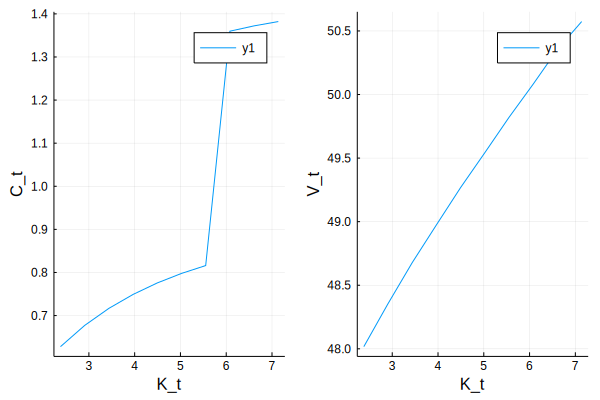

In [19]:
tol = 0.001
V, C = vfi(V0 ,p, tol, kgrid)
plot1 = plot(kgrid, C)
xlabel!(plot1,"K_t")
ylabel!(plot1,"C_t")
plot2 = plot(kgrid, V)
xlabel!(plot2,"K_t")
ylabel!(plot2,"V_t")

plot(plot1, plot2)

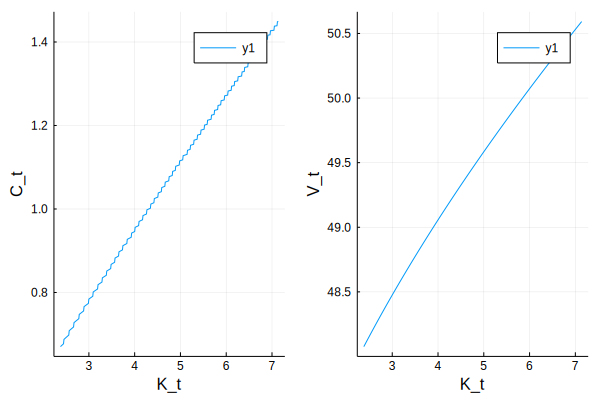

In [20]:
tol = 0.001
V, C = vfi(V0test, p, tol, ktest)
plot1 = plot(ktest, C)
xlabel!(plot1,"K_t")
ylabel!(plot1,"C_t")
plot2 = plot(ktest, V)
xlabel!(plot2,"K_t")
ylabel!(plot2,"V_t")

plot(plot1, plot2)

__Bonus 1: plot a graph showing the convergence back to the steady-state__


__Bonus 2: implement the policy iteration algorithm by adding an evaluation step in the `vfi` function.__
